# Implementação

In [1]:
!pip install pymc3

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

/home/wellington/.sage/local/lib/python3.9/site-packages/theano/scalar/basic.py:2412: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.ctor = getattr(np, o_type.dtype)
/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all n

Modelo que usaremos para modelar a morte de um idioma:

In [3]:
def SIR(y, t, p):
    dt = (1 - y[0])*p[0]*p[1]*(y[0])**p[2] + y[0]*p[0]*(1-p[1])*(1-y[0])**p[2]
    return [dt]

Testando com dados ficticios (os parametros foram chutados):

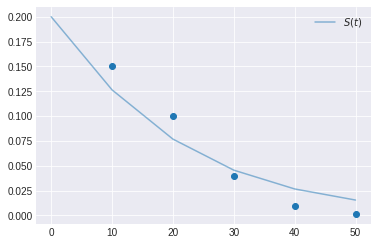

In [4]:
times = np.arange(0, 60, 10)


# Gerando curvas simuladas
y = odeint(SIR, y0=[0.20], t=times, args=((-0.06, 0.1, 1.3),), rtol=1e-8) # argumentos chutados
# dados (nesse caso ficticios)
yobs = np.array([[0.15], [0.10], [0.04], [0.009], [0.001]])

plt.plot(times[1::], yobs, marker='o', linestyle='none')
plt.plot(times, y[:], color='C0', alpha=0.5, label=f'$S(t)$')
plt.legend();

Definição do modelo:

In [5]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(10, 60, 10),
    n_states=1,
    n_theta=3,
    t0=0,
)

/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex(data)  # works for all numeric scalars
/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/basic.py:369: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.complex

Estimação dos parametro (c, s e a):

In [39]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)

    # Distribuições a priori (lower liminf, upper limsup)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    c = pm.Bound(pm.Normal, upper=0)('c', -0.1, 1)
    s = pm.Bound(pm.Normal, lower=0, upper=1)('s', 0.5, 1)
    a = pm.Bound(pm.Normal, lower=0)('a', 1.31, 1)
    
    sir_curves = sir_model(y0=[0.20], theta=[c, s, a])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)
#    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
#    trace = pm.sample(200, tune=100)
    trace = pm.sample(200, tune=100, start={'R0': np.array(2), 'c': np.array(-0.1), 'sigma': np.array([1]), 's': np.array(0.5), 'a': np.array(1.31)})

ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9794271197245D+00   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3005265718229D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1543446145653D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1558, in on_import
    self.set_shape(r, s)
  File "/home/well

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1915136569386D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4302486463916D+02   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1769098126009D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9065002845295D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9021815987908D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8976151743713D+01   r2 =                  NaN


ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    self.on_import(fgraph, node, reason="on_attach")
  File "/home/wellington/.sage/local/lib/python3.9

ERROR (theano.graph.opt): Optimization failure due to: local_useless_reshape
ERROR (theano.graph.opt): node: Reshape{1}((d__logp/dsigma_log__), MakeVector{dtype='int64'}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 4826, in local_useless_reshape
    inpshp_i = shape_feature.get_shape(input, dim)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1137, in get_shape
    r = self.shape_of[var][idx]
KeyError: (d__logp/dsigma_log__)

ERROR (theano.graph.opt): Optimization failure due to: local_shape_

ERROR (theano.graph.opt): Optimization failure due to: local_fill_to_alloc
ERROR (theano.graph.opt): node: Elemwise{second,no_inplace}(Elemwise{sub,no_inplace}.0, Elemwise{switch,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1961, in local_fill_to_alloc
    o = broadcast_like(v, r, fgraph, dtype=v.dtype)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 199, in broadcast_like
    new_shape = fgraph.shape_feature.shape_of[template]
KeyError: Elemwise{sub,no_inplace}.0

ERROR (theano.g

/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6623442789475D+00   r2 =  0.5154410114797D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6623442789475D+00   r2 =  0.5154410114797D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6623442789475D+00   r2 =  0.4081083084394D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6623442789475D+00   r2 =  0.4081083084394D-16
 lsoda--  warning..internal t (=r1) 

/usr/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4747084261642D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1063325215101D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2210355573461D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3915736760697D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4182381015034D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4291503670630D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.2661349459479D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4101820719919D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4071134161146D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3284704427595D+02   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2) 

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 145 seconds.
ERROR (theano.graph.opt): SeqOptimizer apply <theano.tensor.opt.ShapeOptimizer object at 0x7f34e2e59a30>
ERROR (theano.graph.opt): Traceback:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 245, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/opt.py", line 82, in optimize
    self.add_requirements(fgraph)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1681, in add_requirements
    fgraph.attach_feature(ShapeFeature())
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/graph/fg.py", line 565, in attach_feature
    attach(self)
  File "/home/wellington/.sage/local/lib/python3.9/site-packages/theano/tensor/opt.py", line 1491, in on_attach
    se

In [34]:
data = az.from_pymc3(trace=trace)
data

Got error No model on context stack. trying to find log_likelihood in translation.
/home/wellington/.sage/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

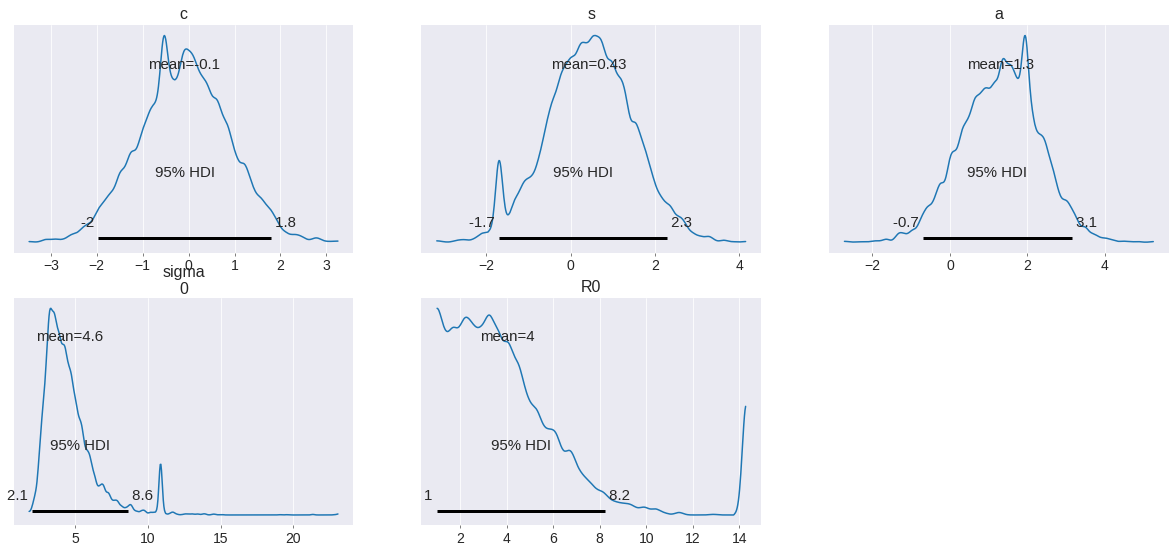

In [35]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);